# 🌊 Deep Dive Into XGBoost
> **작성자 : 오수지 (2022020660)**

안녕하세요, 고려대학교 산업경영공학부 DSBA 연구실 석사과정 오수지입니다.  
이번 노트북 튜토리얼에선 Gradient Boosting 계열 방법론, 그 중에서도 **`XGBoost`**에 대한 실험을 진행할 예정입니다. (🔎 Ensemble Learning에 대한 기본적인 내용은 [유튜브 튜토리얼 영상](https://youtu.be/OqmlPbbI104)을 참고해주세요.)

XGBoost는 parallel processing, tree-pruning, 특별한 missing value 처리 기법, 오버피팅을 피하기 위한 regularization 등을 통해 Gradient Boosting을 한단계 더 발전시킨 **`Optimized Gradient Boosting`** 알고리즘입니다.

기존 Gradient Boosting은 가능한 모든 분기점을 전부 탐색하는 방식으로 분기를 진행하는데, 이 경우 항상 최적의 분기점을 찾을 수 있다는 장점이 있지만, 데이터가 메모리에 모두 저장되지 않을 경우 현실적으로 탐색이 불가능하며 분산 컴퓨팅 환경에서 계산이 불가능하다는 단점이 있습니다. 그래서 XGBoost에서는 데이터를 몇 개의 bin으로 분리한 후 bin 단위로 최적의 Split Point를 찾아나가는 **`Approximate Algorithm`**을 통해 분산 처리를 가능하게 했는데요!

bin의 개수에 따른 output의 변화를 생각해볼 때, 단순히 생각해봐도 bin의 개수가 늘어날수록 최적의 split point를 찾기는 힘들어질 것 같고, 대신 각 bin별 탐색 시간이 줄어드므로 소요 시간은 줄어들 것 같습니다! 과연 실제로도 그럴까요?🤔

이번 튜토리얼에선 강의자료에서 나온 간단한 예제를 통해 bin 개수에 따른 최적의 split point를 찾을 성공 확률과 소요 시간 변화를 알아보고, 실제 데이터를 이용해 greedy algorithm과 approximate algorithm 별 성능 차이를 확인해보겠습니다! 과연 XGBoost가 **`최적화된`** Gradient Boosting이 맞을지...!😎

<img src="images/xgb_title.png" width="600">

**📌 이번 튜토리얼의 목표 (Focus on Split Finding Algorithm)**
>1. 간단한 예제를 이용한 **`Bin 개수`**에 따른 **`최적의 Split Point를 찾을 확률`** 및 **`소요 시간`** 변화 확인
>2. 실제 데이터를 이용한 **`Exact greedy algorithm vs Approximate greedy algorithm`**

**📌 Reference**
- https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d
- [강필성 교수님 Business Analytics 수업 강의자료](https://github.com/pilsung-kang/Business-Analytics-IME654-/blob/master/04%20Ensemble%20Learning/04-7_Ensemble%20Learning_XGBoost.pdf)
- https://xgboost.readthedocs.io/en/stable/parameter.html

## 🛠 환경 설정

In [64]:
!pip install xgboost
!pip install xlrd==2.0.1  # for read xsl file
!pip install openpyxl  # for read xslx file

     |████████████████████████████████| 96 kB 7.1 MB/s  eta 0:00:01
     |████████████████████████████████| 242 kB 20.5 MB/s eta 0:00:01


In [71]:
import numpy as np
import pandas as pd
import random
import math
from tqdm.auto import tqdm
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
warnings.filterwarnings(action='ignore') 
import copy
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style="whitegrid")
sns.set_color_codes()
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics
import xgboost as xgb

In [3]:
def seed_everything(seed: int = 1201):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything()

## 1️⃣ **`Bin 개수`**에 따른 **`최적의 Split Point를 찾을 확률`** 및 **`소요 시간`** 변화 확인
> 강필성 교수님의 Business Analytics 수업에 나온 Illustrative example을 바탕으로 Bin 개수에 따른 최적의 Split Point를 찾을 확률과 소요 시간 변화를 확인해보겠습니다.  


<img src="images/xgb_example.png" width="600">

In [4]:
sample = pd.Series([0] * 18 + [1] * 22)
print(list(sample))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### ① Entropy 계산
- Entropy 수식을 이용해 데이터의 Impurity를 계산합니다.
- 데이터가 Impure할수록 데이터가 가지고 있는 정보량이 많으므로 Entropy는 커지고, Pure할수록 Entropy는 작아집니다.
- 하나의 값으로만 데이터가 구성이 되어있다면 Entropy는 0으로 최솟값을 가지며, 2개의 값이 1:1의 비율로 구성이 되어있다면 Entropy는 1로 최댓값을 가집니다.

In [5]:
def compute_entropy(inputs):
    probs = inputs.value_counts(normalize=True)
    entropy = -1 * np.sum(np.log2(probs) * probs)
        
    return(round(entropy, 3))

In [6]:
# Case 1 : 데이터가 하나의 클래스로만 구성된 경우 => entropy = 0
compute_entropy(pd.Series([0]*40))

-0.0

In [7]:
# Case 2 : 데이터가 2개의 클래스, 1:1의 비율로 구성된 경우 => entropy = 1
compute_entropy(pd.Series([0]*20 + [1]*20))

1.0

In [8]:
# 현재 sample의 entropy 
compute_entropy(sample)

0.993

### ② Max Information Gain 및 Split Point 탐색

In [18]:
def find_max_information_gain(inputs, k=None, do_print=True):
    max_ig, max_ig_idx = 0, 0
    
    # if the number of split point is provided
    if k:
        start = datetime.now()
        bin_len = int(len(inputs) // k)
        bins = [inputs[i*bin_len:(i+1)*bin_len] for i in range(k)]

        for idx, bin in enumerate(bins):
            entropy_before = compute_entropy(bin)
            for i in range(len(bin)-1):
                g1, g2 = bin[:i+1], bin[i+1:]
                g1_entropy, g2_entropy = compute_entropy(g1), compute_entropy(g2)
                entropy_after = g1_entropy + g2_entropy
                ig = entropy_before - entropy_after
                if ig > max_ig:
                    max_ig_idx = (bin_len-1)*idx+(i+1)+idx
                    max_ig = ig
        end = datetime.now()
        diff =  end - start
        time = round(diff.microseconds / 1000, 2)
    # if the number of split point is not provided
    else:
        start = datetime.now()
        entropy_before = compute_entropy(inputs)
        for i in range(len(inputs)-1):
            g1, g2 = inputs[:i+1], inputs[i+1:]
            g1_entropy, g2_entropy = compute_entropy(g1), compute_entropy(g2)
            entropy_after = g1_entropy + g2_entropy
            ig = entropy_before - entropy_after
            if ig > max_ig:
                max_ig_idx = i+1
                max_ig = ig
        end = datetime.now()
        diff =  end - start
        time = round(diff.microseconds / 1000, 2)

    if do_print:
        print("="*50)
        print(f"The number of bins : {k}")
        print(f"Maximum Information Gain : {max_ig}")
        print(f"Maximum Information Gain Index: {max_ig_idx}")
        print(f"Group1 : {str(list(inputs[:max_ig_idx]))}")
        print(f"Group2 : {str(list(inputs[max_ig_idx:]))}")
        print("MilliSecond difference : ", time)
        print("="*50)

    if k:
        return max_ig, max_ig_idx, time
    return max_ig, max_ig_idx

### 📌 Basic Exact Greedy Algorithm
<img src="images/xgb_algo_1.png" width="600">

In [19]:
# 분할없이 전체 데이터에 대해 탐색하는 경우 최대 information gain과 그때의 idx
find_max_information_gain(sample)

The number of bins : None
Maximum Information Gain : 0.984
Maximum Information Gain Index: 17
Group1 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group2 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
MilliSecond difference :  94.78


(0.984, 17)

### 📌 Approximate Algorithm
<img src="images/xgb_algo_2.png" width="600">

In [11]:
# 전체 데이터를 10분할 후, 각 분할에 대해서 개별적으로 information gain을 찾는 경우 최대 information gain과 그때의 idx
find_max_information_gain(sample, 10)

The number of bins : 10
Maximum Information Gain : 1.0
Maximum Information Gain Index: 18
Group1 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group2 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
MilliSecond difference :  70.09


(1.0, 18, 70.09)

- bin 개수별 최적의 split point 및 소요 시간을 확인해보겠습니다.

In [12]:
k_candidates = [i for i in range(2, 40) if len(sample)%i==0]
k_candidates

[2, 4, 5, 8, 10, 20]

- bin의 개수가 20일 때를 제외하고 모든 경우에서 최적의 split point를 찾은 것을 확인할 수 있습니다.
- 특히 bin의 개수가 늘어날수록 소요 시간은 줄어들고 있는 점도 확인할 수 있었습니다.

In [13]:
for k in k_candidates:
    find_max_information_gain(sample, k)

The number of bins : 2
Maximum Information Gain : 0.469
Maximum Information Gain Index: 18
Group1 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group2 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
MilliSecond difference :  90.75
The number of bins : 4
Maximum Information Gain : 0.722
Maximum Information Gain Index: 18
Group1 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group2 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
MilliSecond difference :  72.12
The number of bins : 5
Maximum Information Gain : 0.811
Maximum Information Gain Index: 18
Group1 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group2 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
MilliSecond difference :  69.46
The number of bins : 8
Maximum Information Gain : 0.971
Maximum Information Gain Index: 18
Group1 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group2 : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

### 🔎 Bin 개수에 따른 최적의 Split Point를 찾을 확률 및 소요 시간 변화
> 총 100개의 데이터를 랜덤으로 생성해 Bin 개수에 따른 최적의 Split Point를 찾을 확률 및 소요 시간을 측정했습니다. 그 결과 강의 시간에 배운 것처럼 **Bin 개수가 늘어날수록 성능과 소요 시간 모두 감소**하고 있는 것을 확인할 수 있었습니다. 여기서 Bin별 연산을 실제 구현 코드처럼 병렬 처리해준다면 Bin 개수가 늘어날수록 소요 시간 감소의 폭이 더 커질 것으로 예상됩니다.

In [14]:
n_success = 0
k_success_cnt = [0] * len(k_candidates)
k_success_time = [0] * len(k_candidates)

while n_success < 100:
    sample = pd.Series(sorted(np.random.randint(2, size = 40)))
    ig, ig_idx = find_max_information_gain(sample, do_print=False)
    if ig != 0:
        n_success += 1
        for idx, k in enumerate(k_candidates):
            k_ig, k_ig_idx, k_time = find_max_information_gain(sample, k, do_print=False)
            if k_ig_idx == ig_idx:
                k_success_cnt[idx] += 1
                k_success_time[idx] += k_time

In [20]:
k_success_prob = [cnt/n_success for cnt in k_success_cnt]
k_success_time = [time/n_success for time in k_success_time]

In [25]:
bin_df = pd.DataFrame({'K': k_candidates, 'Success Probability': k_success_prob, 'Elapsed Time (ms)': k_success_time})

- **최적의 Split Point를 찾을 확률** : Bin의 개수가 늘어날수록 감소

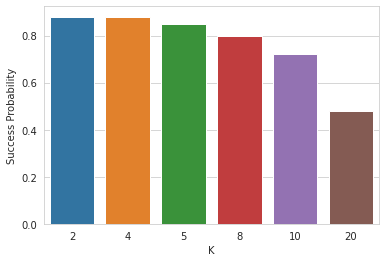

In [26]:
sns.barplot(data=bin_df, x="K", y="Success Probability")

- **소요 시간** : Bin의 개수가 늘어날수록 감소

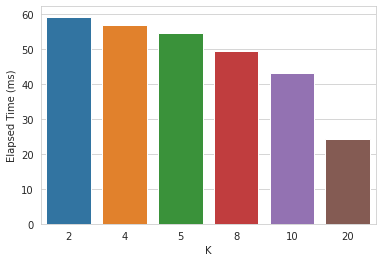

In [27]:
sns.barplot(data=bin_df, x="K", y="Elapsed Time (ms)")

## 2️⃣ **`Exact greedy algorithm vs Approximate greedy algorithm`**
> 실제 데이터셋에 대해 Exact greedy algorithm, Approximate greedy algorithm 각 알고리즘 별 성능 변화를 확인해보겠습니다.

### ① 데이터 준비
> 가장 기본적인 iris 데이터셋이나 breast cancer 데이터셋으로 실험을 진행한 결과 모든 옵션에서 다 비슷하게 좋은 성능이 나와서 정확한 비교가 어렵다고 판단했습니다. 그러므로 3강 튜토리얼인 Text Classification using SVM에서 구축한 EMNLP, CVPR 논문 제목을 이용한 이진 분류 데이터셋을 이용했습니다.

In [65]:
emnlp = pd.read_excel('./data/emnlp_2022_accepted_papers.xls')
cvpr = pd.read_excel('./data/cvpr_2022_accepted_papers.xlsx', engine='openpyxl')

In [66]:
titles, labels = [], []

for emnlp_title in list(emnlp['Title']):
    titles.append(emnlp_title)
    labels.append('EMNLP')
    
for cvpr_title in list(cvpr['Paper Title']):
    titles.append(cvpr_title)
    labels.append('CVPR')

In [67]:
data = pd.DataFrame({'Title': titles, 'Label': labels})

In [69]:
X_train, X_test, y_train, y_test = train_test_split(data['Title'], data['Label'], 
                                                    shuffle=True, test_size = 0.2, random_state = 1201)

In [72]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [73]:
tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(data['Title'])
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [74]:
X_train_tfidf.shape, X_test_tfidf.shape

((2756, 4981), (690, 4981))

### ② 성능 확인
<img src="images/xgb_tree_method.png" width="600">

- tree_method 파라미터를 통해 Exact greedy algorithm과 Approximate greedy algorithm에 대한 비교 실험을 진행할 수 있습니다.
- Reference
    - https://xgboost.readthedocs.io/en/stable/parameter.html

In [100]:
def print_result(y_pred):
    print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)*100:.2f}")
    print(f"Precision: {metrics.precision_score(y_test, y_pred)*100:.2f}")
    print(f"Recall: {metrics.recall_score(y_test, y_pred)*100:.2f}")
    print(f"F1-Score: {metrics.f1_score(y_test, y_pred)*100:.2f}")

In [101]:
exact_xgb = xgb.XGBClassifier(tree_method="exact")
approx_xgb = xgb.XGBClassifier(tree_method="approx")

In [102]:
exact_xgb.fit(X_train_tfidf, y_train)
approx_xgb.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='approx', verbosity=1)

In [103]:
exact_y_pred = exact_xgb.predict(X_test_tfidf)
approx_y_pred = approx_xgb.predict(X_test_tfidf)

- 모든 성능 지표에서 Exact greedy algorithm을 수행했을 때보다 Approximate greedy algorithm을 수행했을 때 더 좋은 성능을 보인 것을 확인할 수 있었습니다.

In [104]:
print_result(exact_y_pred)

Accuracy: 83.62
Precision: 90.62
Recall: 64.68
F1-Score: 75.49


In [105]:
print_result(approx_y_pred)

Accuracy: 83.91
Precision: 91.15
Recall: 65.06
F1-Score: 75.92


- 여기까지 수행했을 때 한 가지 더 궁금한 점이 생겼습니다. 현재 전체 데이터샛 개수는 3,446개, 그 중에서도 train 데이터셋은 2,756개인데 2,756개는 큰 데이터셋이라고 봐야할까요 작은 데이터셋이라고 봐야할까요?!
- 데이터셋의 개수가 더 작을 때, 정확히 기존 데이터셋 개수의 1/2일 때, 각 알고리즘에 따른 성능 변화를 확인해보겠습니다!

In [108]:
small_titles, small_labels = [], []

for emnlp_title in list(emnlp['Title'][:int(len(emnlp)//2)]):
    small_titles.append(emnlp_title)
    small_labels.append('EMNLP')
    
for cvpr_title in list(cvpr['Paper Title'][:int(len(cvpr)//2)]):
    small_titles.append(cvpr_title)
    small_labels.append('CVPR')
    
small_data = pd.DataFrame({'Title': small_titles, 'Label': small_labels})

small_X_train, small_X_test, small_y_train, small_y_test = train_test_split(small_data['Title'], small_data['Label'], 
                                                    shuffle=True, test_size = 0.2, random_state = 1201)

small_y_train = label_encoder.fit_transform(small_y_train)
small_y_test = label_encoder.fit_transform(small_y_test)

tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(small_data['Title'])
small_X_train_tfidf = tfidf.transform(small_X_train)
small_X_test_tfidf = tfidf.transform(small_X_test)

In [110]:
len(data), len(small_data)

(3446, 1722)

In [112]:
small_exact_xgb = xgb.XGBClassifier(tree_method="exact")
small_approx_xgb = xgb.XGBClassifier(tree_method="approx")
small_exact_xgb.fit(small_X_train_tfidf, small_y_train)
small_approx_xgb.fit(small_X_train_tfidf, small_y_train)
small_exact_y_pred = small_exact_xgb.predict(small_X_test_tfidf)
small_approx_y_pred = small_approx_xgb.predict(small_X_test_tfidf)

In [114]:
small_exact_y_pred = small_exact_xgb.predict(small_X_test_tfidf)
small_approx_y_pred = small_approx_xgb.predict(small_X_test_tfidf)

In [116]:
def print_result_small(y_pred):
    print(f"Accuracy: {metrics.accuracy_score(small_y_test, y_pred)*100:.2f}")
    print(f"Precision: {metrics.precision_score(small_y_test, y_pred)*100:.2f}")
    print(f"Recall: {metrics.recall_score(small_y_test, y_pred)*100:.2f}")
    print(f"F1-Score: {metrics.f1_score(small_y_test, y_pred)*100:.2f}")

- 데이터셋 개수가 절반이 되었을 때, Exact greedy algorithm의 성능은 Accuracy 기준 83.62에서 79.13으로 4.49 하락했으며, Approximate greedy algorithm의 성능은 83.91에서 80.29로 3.61 하락했습니다. 
- 결론적으로 데이터셋이 3,446개에서 1,722개로 줄어들었을 때도 여전히 Approximate greedy algorithm을 사용했을 때의 성능이 더 좋은 점을 확인할 수 있었습니다.
- 공식 홈페이지를 확인해보면, tree_method 파라미터를 `auto`로 지정할 경우, small dataset일 경우 exact greedy algorithm, larger dataset일 경우, approximate algorithm이 사용된다고 하는데 데이터셋이 3,446개에서 1,722개로 줄어들었을 때도 여전히 Approximate greedy algorithm을 사용했을 때의 성능이 더 좋은 점을 생각해보면 `small dataset`의 기준이 무엇일지 궁금해지는 마무리였습니다.


In [118]:
print_result_small(small_exact_y_pred)

Accuracy: 79.13
Precision: 86.54
Recall: 60.81
F1-Score: 71.43


In [119]:
print_result_small(small_approx_y_pred)

Accuracy: 80.29
Precision: 89.22
Recall: 61.49
F1-Score: 72.80


> 강의 시간에 교수님께서 던져주신 주제에 대한 정답을 직접 찾아보는 재밌는 시간이었습니다. 그럼 다음 튜토리얼에 **`Semi-supervised Learning`**으로 다시 찾아뵙겠습니다.

<img src="images/9_turtle.png" width="300">